# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [ ]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [ ]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [ ]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

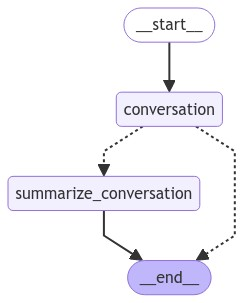

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_18873/2173919996.py:55: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]


================================== Ai Message ==================================

Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!
================================== Ai Message ==================================

Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?
================================== Ai Message ==================================

That's awesome, Lance! The San Francisco 49ers have a rich history and a passionate fan base. Is there a specific aspect of the team you'd like to discuss? For example, we could talk about:

- Their legendary players like Joe Montana and Jerry Rice
- Memorable games and Super Bowl victories
- The current roster and season prospects
- Rivalries, like the one with the Seattle Seahawks
- Levi's Stadium and

Let's confirm that our state is saved locally.

In [ ]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", id='d5bb4b3f-b1e9-4f61-8c75-7a7210b30253'), AIMessage(content="Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 337, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'stop', 'logprobs': None}, id='run-dde04d51-d305-4a9e-8ad5-6bdf5583196e-0', usage_metadata={'input_tokens': 337, 'output_tokens': 50, 'total_tokens': 387}), HumanMessage(content="what's my name?", id='d7530770-f130-4a05-a602-a96fd87859c6'), AIMessage(content='Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?', additional_kwargs={'

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", id='d5bb4b3f-b1e9-4f61-8c75-7a7210b30253'), AIMessage(content="Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 337, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'stop', 'logprobs': None}, id='run-dde04d51-d305-4a9e-8ad5-6bdf5583196e-0', usage_metadata={'input_tokens': 337, 'output_tokens': 50, 'total_tokens': 387}), HumanMessage(content="what's my name?", id='d7530770-f130-4a05-a602-a96fd87859c6'), AIMessage(content='Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?', additional_kwargs={'

----------------------------- Experiments -----------------------------------

In [1]:
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3 as sql

In [2]:
import os
from dotenv import load_dotenv

In [3]:
con = sql.connect("chat_history.db", check_same_thread=False)
memory = SqliteSaver(con)

In [4]:
load_dotenv()
CHAT_LLAMA = os.getenv("CHAT_LLAMA")

In [5]:
model = ChatGroq(model=CHAT_LLAMA)

In [6]:
class State(MessagesState):
    """State maintainer for summary and messages"""
    summary: str

In [7]:
def conversation(state:State):

    summary = state.get('summary')

    if summary:
        system_message = f"The following is the summary of our conversation so far: {summary}."
        messages = [SystemMessage(content=system_message)]+state['messages']
    else:
        messages = state['messages']

    output = model.invoke(messages)

    return ({'messages':output})

In [8]:
def summarization(state:State):
    
    summary = state.get('summary')

    if summary:
        new_summary = f"Here the summary of our conversation so far:{summary}, create a new summary using the new conversation messages above."
    else:
        new_summary = f"Create the summary of the above conversation"

    output = model.invoke(state['messages']+[HumanMessage(content=new_summary)])
    recent_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]

    return {'summary':output.content, 'messages':recent_messages}

In [9]:
def should_continue(state:State):
    """Returns the next node for execution."""
    messages = state['messages']
    if len(messages)>6:
        return "summarization"
    else:
        return END

In [10]:
builder = StateGraph(State)

builder.add_node('conversation', conversation)
builder.add_node('summarization', summarization)

builder.add_edge(START,'conversation')
builder.add_conditional_edges('conversation',should_continue)
builder.add_edge('summarization',END)

graph = builder.compile(checkpointer=memory)

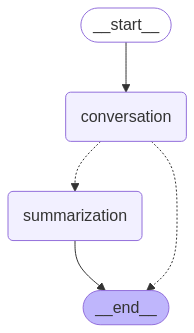

In [11]:
graph

In [13]:
config={'configurable':{'thread_id':'thread1'}}

In [ ]:

# Start conversation
input_message = HumanMessage(content="hi! I'm Mark")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()



================================== Ai Message ==================================

Nice to meet you, Mark! How are you doing today?


In [15]:
input_message = HumanMessage(content="Im doing fine how about you?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to chat with you. What brings you here today, Mark? Is there something on your mind that you'd like to talk about or ask?


In [16]:
input_message = HumanMessage(content="I like cricket")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Cricket is a fantastic sport! It's a great game that requires skill, strategy, and teamwork. Which aspect of cricket do you enjoy the most? Is it the thrill of playing the game, watching international matches, or following a particular team or player?


In [17]:
input_message = HumanMessage(content="I am a fan of Sachin Tendulkar")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

A legendary choice! Sachin Tendulkar is widely regarded as one of the greatest batsmen in the history of cricket. His career was filled with incredible achievements, and he earned the nickname "The Little Master" for his exceptional skill and technique. What is it about Sachin Tendulkar that you admire the most? Is it his incredible records, his elegant strokeplay, or his dedication to the sport?


In [18]:
input_message = HumanMessage(content="what do you know about me?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Not much, actually! We just started our conversation, and I've learned that you're a fan of Sachin Tendulkar. I'm an AI, so I don't have personal experiences or emotions, but I can certainly chat with you about your interests. If you'd like to share more about why you admire Sachin Tendulkar or discuss cricket in general, I'm here to listen!


In [19]:
output

{'messages': [HumanMessage(content='I am a fan of Sachin Tendulkar', additional_kwargs={}, response_metadata={}, id='9855840a-b1bb-4c20-89dc-a7c6a3a8a6fc'),
  AIMessage(content='A legendary choice! Sachin Tendulkar is widely regarded as one of the greatest batsmen in the history of cricket. His career was filled with incredible achievements, and he earned the nickname "The Little Master" for his exceptional skill and technique. What is it about Sachin Tendulkar that you admire the most? Is it his incredible records, his elegant strokeplay, or his dedication to the sport?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 179, 'total_tokens': 263, 'completion_time': 0.345548838, 'prompt_time': 0.009207835, 'queue_time': 0.049888305, 'total_time': 0.354756673}, 'model_name': 'meta-llama/llama-4-maverick-17b-128e-instruct', 'system_fingerprint': 'fp_253f463456', 'finish_reason': 'stop', 'logprobs': None}, id='run-b18cb242-fee3-45d5-85f8-d0

In [20]:
input_message = HumanMessage(content="Who is the prime minister of India?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

That's a straightforward question! As of my last update, the Prime Minister of India is Narendra Modi. He has been serving as the Prime Minister since 2014. If you're looking for more information or updates, I can try to provide it.


In [21]:
input_message = HumanMessage(content="what do you know about him?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Narendra Modi is an Indian politician who has been serving as the Prime Minister of India since 2014. He is the leader of the Bharatiya Janata Party (BJP). Prior to becoming the Prime Minister, he served as the Chief Minister of Gujarat from 2001 to 2014. As the Prime Minister, he has been a significant figure in Indian politics, implementing various policies and reforms. If you're looking for more information about his tenure or policies, I can try to provide it.


In [22]:
len(output['messages'])

2

In [23]:
input_message = HumanMessage(content="Who is the foreign minister of india?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

len(output['messages'])


================================== Ai Message ==================================

The current Foreign Minister of India is S. Jaishankar. He has been serving as the Minister of External Affairs since 2019, and has been a key figure in shaping India's foreign policy. As a seasoned diplomat and politician, he has played a significant role in representing India's interests globally.


4

In [24]:
input_message = HumanMessage(content="Who is the ceo of tcs?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

len(output['messages'])

================================== Ai Message ==================================

The CEO of Tata Consultancy Services (TCS) is K. Krithivasan. However, it's worth noting that Tata Consultancy Services is an Indian multinational company and its global CEO is Natarajan Chandrasekaran (also known as N. Chandrasekaran), not K. Krithivasan. Natarajan Chandrasekaran is an Indian businessman who has been serving as the Chairman of Tata Sons, the holding company of the Tata Group, and has also held the position of the Managing Director of Tata Consultancy Services.


6

In [25]:
input_message = HumanMessage(content="what is the population of manipur?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

len(output['messages'])

================================== Ai Message ==================================

According to the 2011 census, the population of Manipur is approximately 2.86 million (or 28.57 lakh). However, more recent estimates may be available. As of 2020, the estimated population is around 3.2 million. Manipur is a state in northeastern India, and its population has been steadily growing. For the most up-to-date information, you can check the latest available data from reliable sources such as the Census of India or other government publications.


2

In [26]:
from pprint import pprint
pprint(output['summary'])

('Here is a summary of our conversation:\n'
 '\n'
 "1. You initially mentioned that you're a fan of Sachin Tendulkar, and I "
 'responded accordingly.\n'
 '2. You then inquired about my knowledge regarding "him", and I clarified '
 'that we had just started our conversation.\n'
 '3. You asked about the current Prime Minister of India, and I informed you '
 'that Narendra Modi is the current Prime Minister.\n'
 '4. You then inquired about what I know regarding "him", and I provided some '
 "information about Narendra Modi's background and tenure.\n"
 '5. You were asked to summarize our conversation.\n'
 '\n'
 'To continue the conversation, you asked about the Foreign Minister of India, '
 'the CEO of TCS, and the population of Manipur, and I provided the respective '
 'information.\n'
 '\n'
 'To summarize:\n'
 '\n'
 '* The current Foreign Minister of India is S. Jaishankar.\n'
 '* The CEO of Tata Consultancy Services (TCS) is K. Krithivasan, although the '
 'global CEO of the Tata Group

In [27]:
input_message = HumanMessage(content="Who am I?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

You are a user who is having a conversation. You initially mentioned being a fan of Sachin Tendulkar, and then you inquired about various topics including the current Prime Minister of India, the Foreign Minister of India, the CEO of TCS, and the population of Manipur. I provided the respective information. 

To summarize, the current Foreign Minister of India is S. Jaishankar, the CEO of Tata Consultancy Services (TCS) is K. Krithivasan (although the global CEO of the Tata Group is Natarajan Chandrasekaran), and the population of Manipur is approximately 2.86 million (or 28.57 lakh) according to the 2011 census, and around 3.2 million as of 2020.


In [15]:
input_message = HumanMessage(content="what is my name?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

You haven't told me your name. I'm happy to chat with you, but I don't know your name as we are interacting through text. If you'd like to share your name, I can certainly respond accordingly, but since this is the beginning of our conversation, I'll simply say that I'm here to help with any questions you may have.


In [29]:
input_message = HumanMessage(content="provide me a summary of our conversation so far?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Here's a summary of our conversation so far:

1. You initially mentioned that you're a fan of Sachin Tendulkar.
2. You then inquired about my knowledge regarding "him", and I clarified that we had just started our conversation.
3. You asked about the current Prime Minister of India, and I informed you that Narendra Modi is the current Prime Minister.
4. You then inquired about what I know regarding "him", and I provided some information about Narendra Modi's background and tenure.
5. You were asked to summarize our conversation.

To continue the conversation, you asked about the Foreign Minister of India, the CEO of TCS, and the population of Manipur, and I provided the respective information.

To summarize:

* The current Foreign Minister of India is S. Jaishankar.
* The CEO of Tata Consultancy Services (TCS) is K. Krithivasan, although the global CEO of the Tata Group is Natarajan Chandrasekaran.
* The 

In [30]:
input_message = HumanMessage(content="What is nvidia cuda?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

NVIDIA CUDA (Compute Unified Device Architecture) is a parallel computing platform and programming model developed by NVIDIA Corporation. It allows developers to harness the power of NVIDIA graphics processing units (GPUs) for general-purpose computing, beyond just graphics rendering.

CUDA is a software layer that enables developers to write programs that can execute on NVIDIA GPUs, leveraging their massive parallel processing capabilities. This allows for significant performance improvements in various compute-intensive tasks, such as:

1. Scientific simulations
2. Data analytics and machine learning
3. Cryptography
4. Weather forecasting and climate modeling
5. Medical imaging and diagnostics

CUDA provides a set of APIs, libraries, and tools that allow developers to:

1. Write CUDA kernels: These are the core functions that execute on the GPU.
2. Use CUDA libraries: Pre-built libraries that provide hi

In [31]:
input_message = HumanMessage(content="Who was aristotal?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Aristotle (384-322 BCE) was a Greek philosopher and polymath who made significant contributions to various fields, including philosophy, science, and ethics. He was one of the most influential figures of the ancient world, and his works had a profound impact on Western philosophy and science.

Aristotle was born in Stagira, a small town in ancient Macedonia, and studied under Plato at the Academy in Athens. He later tutored Alexander the Great, the famous Macedonian king.

Some of Aristotle's most notable achievements and contributions include:

1. **Philosophy**: Aristotle made significant contributions to various branches of philosophy, including metaphysics, ethics, politics, and biology. His works include "Metaphysics," "Nicomachean Ethics," and "Politics."
2. **Biology and Natural History**: Aristotle was a pioneer in the field of biology, and his works on natural history, such as "Historia Animalium

In [32]:
len(output['messages'])

6

In [33]:
input_message = HumanMessage(content="how many planets are in solar system?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    

================================== Ai Message ==================================

There are 8 planets in our solar system. Here is the list of planets in our solar system, in order from the Sun:

1. Mercury
2. Venus
3. Earth
4. Mars
5. Jupiter
6. Saturn
7. Uranus
8. Neptune

These 8 planets are the primary planets in our solar system. In addition to these, there are also other objects in the solar system, such as:

* Dwarf planets (e.g., Pluto, Eris, Ceres)
* Asteroids
* Comets
* Kuiper belt objects
* Oort cloud objects

The 8 planets listed above are the primary planets in our solar system, and they are the most significant objects orbiting the Sun. The other objects mentioned are also part of our solar system, but they are not considered planets.

It's worth noting that Pluto was previously considered the 9th planet, but in 2006, the International Astronomical Union (IAU) redefined the term "planet" and reclassified Pluto as a dwarf planet.


In [34]:
output['summary']

"Here is a summary of our conversation so far:\n\n1. You asked about NVIDIA CUDA, and I provided information about it.\n2. You inquired about Aristotle, and I gave a detailed overview of his life and contributions.\n3. You asked about the number of planets in our solar system, and I provided the list of planets and additional information about other objects in the solar system.\n\nLet's continue the conversation if you'd like to discuss any of these topics further or explore new ones!"

In [14]:
graph.get_state(config).values.get("summary")

"Here is a summary of our conversation so far:\n\n1. You asked about NVIDIA CUDA, and I provided information about it.\n2. You inquired about Aristotle, and I gave a detailed overview of his life and contributions.\n3. You asked about the number of planets in our solar system, and I provided the list of planets and additional information about other objects in the solar system.\n\nLet's continue the conversation if you'd like to discuss any of these topics further or explore new ones!"